# Before we start

You need to download four topograph files before you start.

Download 'piezo_calibration' folder from the following link:

https://drive.google.com/file/d/1NhtqsD_UeYr186sQ4HQAMpbLeIkWOgDu/view?usp=sharing

Make sure that d1.sxm to d4.sxm files are in the same folder as this notebook.

# Import packages and pre-define functions

In [1]:
%pylab inline
import stmpy
import scipy as sp
pylab.style.use('Thin')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#pre-defined functions
def distance(x1, x2, p=[1,1]):
    """
    Compute the distance between two points, x1 and x2, with a shear vector p as optional argument.
    Input:
    x1:    required    1x2 array/list, coordinate of point1
    x2:    required    1x2 array/list, coordinate of point2
    p:     optional    1x2 array/list, shear vactor, including deviation factor in the x and y piezos
    
    Output:
    Distance between x1 and x2:    Number
    """
    a1 = p[0]
    a2 = p[1]
    return sqrt(a1**2*(x1[0]-x2[0])**2+a2**2*(x1[1]-x2[1])**2)

def chi(X):
    """
    Residual function for optimization.
    """
    return abs(distance(x1, x2, X)-q_delta)+\
        abs(distance(x3, x4, X)-q_delta)+\
        abs(distance(x2,x3,X)-q_edge)+\
        abs(distance(x1,x3,X)-q_edge)

# Simulation to find relation between topo and fft patterns in q-space

Let's find out the relation between real space lattice constant and q-space Brag peak separations.

[(500.0, 516.0), (516.0, 500.0), (484.0, 500.0), (500.0, 484.0)]
1984.0


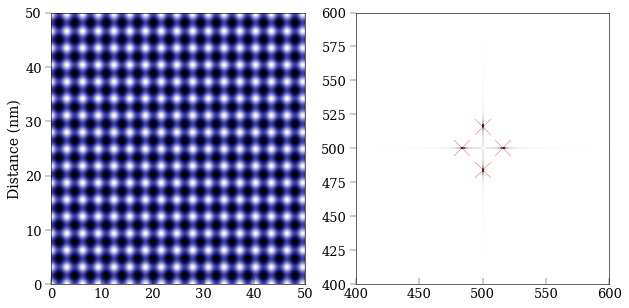

In [3]:
#generating height map 
Pixels = 1000 #map size, in pixels
Length = 50#map size, in nm
d = 3.1 #lattice constant, in nm

a = linspace(0, Length, Pixels)
x, y = meshgrid(a, a)
z = cos(x*2*pi/d)+cos(y*2*pi/d)

z_fft =  stmpy.tools.fft(z, zeroDC=True)
peaks = stmpy.tools.find_extrema(z_fft, n = (5,0), minDist=10)
            
fig, ax = subplots(1,2,figsize=[10,5])
ax[0].imshow(z, cmap=stmpy.cm.blue2, extent=[0,Length,0,Length])
ax[0].set_ylabel('Distance (nm)')

ax[1].imshow(z_fft,  clim=[0,1e5],cmap=stmpy.cm.gray_r)
#stmpy.image.add_colorbar(ax=ax[1])
ax[1].plot(peaks[:,1], peaks[:,0], 'rx',ms=16)
ax[1].set_xlim(400,600)
ax[1].set_ylim(400,600)
print([(i, j) for (i,j) in zip(peaks[:,1], peaks[:,0])])
print(3.1*1000/50*(516-484))

[(500.0, 578.0), (578.0, 500.0), (422.0, 500.0), (500.0, 422.0)]
2010.9375


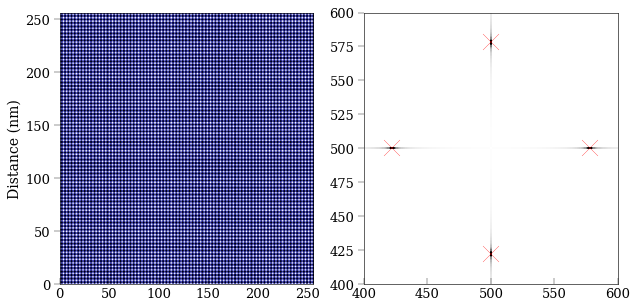

In [4]:
Pixels = 1000 #map size, in pixels
Length = 256#map size, in nm
d = 3.3 #lattice constant, in nm

a = linspace(0, Length, Pixels)
x, y = meshgrid(a, a)
z = cos(x*2*pi/d)+cos(y*2*pi/d)

z_fft =  stmpy.tools.fft(z, zeroDC=True)
peaks = stmpy.tools.find_extrema(z_fft, n = (5,0), minDist=10)
            
fig, ax = subplots(1,2,figsize=[10,5])
ax[0].imshow(z, cmap=stmpy.cm.blue2, extent=[0,Length,0,Length])
ax[0].set_ylabel('Distance (nm)')

ax[1].imshow(z_fft,  clim=[0,1e5],cmap=stmpy.cm.gray_r)
#stmpy.image.add_colorbar(ax=ax[1])
ax[1].plot(peaks[:,1], peaks[:,0], 'rx',ms=16)
ax[1].set_xlim(400,600)
ax[1].set_ylim(400,600)
print([(i, j) for (i,j) in zip(peaks[:,1], peaks[:,0])])
print(3.3*1000/256*(578-422))

__Left: Lattice in real space__ 

__Right: Corresponding fft pattern__


* Notice that the product of d (in the unit of pixels) and $\Delta$q (along diagonal direction) is a constant:

 $\mathbf{d \times\Delta q = 2000 = 2\times Length}$

 e.g., $\underbrace{(3.3 \ nm\times\frac{1000\ pixels}{256\ nm})}_{d\ in\ pixels}\times 
    \underbrace{(578\ pixel^{-1}-422\ pixel^{-1})}_{\Delta k\ in\ pixels^{-1}} 
    = 2010.9375 \approx 2\times\underbrace{1000}_{Image\ Size}$
 
 ,where d = 3.3 nm is the lattice constant, $\Delta q=156$ is Bragg peak separation in the repeating plane direction    (diagonal direction in this case), and Length = 1000 is the image size.

* Another point to notice is that __a larger image size__ can give a better q-space resolution, and thus can give a better result in calibrating the piezos.

In summary, we got 

$\Delta q= 2\times\frac{Length}{d}$

(All the simulations above were designed to obtain the factor of 2)


# Plot the data and corresponding fft

In [5]:
#Both d1 and d2 were taken at 0 degrees
d1 = stmpy.load('d1.sxm')
d2 = stmpy.load('d2.sxm')



|Filename | Setpoint       | Image size |Correct calibration?|Scan Direction|
|-----    |----------------|------------|---------|----------|
|d1       |800mV/100pA|20 nm with 128 pts |No|Upwards|
    |d2   |800mV/100pA |20 nm with 128 pts|No|Downwards|
    |d3   |800mV/200pA|15 nm with 512 pts|No |Upwards|
    |d4   |800mV/200pA |15 nm with 512 pts|Yes |Upwards|

[[102.0, 82.0], [26.0, 46.0], [45.0, 98.0], [83.0, 30.0]]


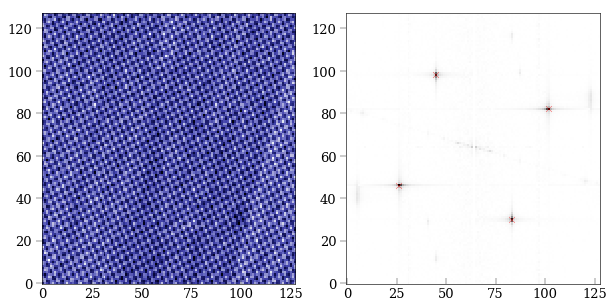

In [6]:
d1.z = stmpy.tools.lineSubtract(d1.Z, 1)
fig, ax = subplots(1,2, figsize=[10,5])
ax[0].imshow(d1.z, cmap=stmpy.cm.blue2)

d1.fft = stmpy.tools.fft(d1.z, zeroDC=True)
peaks = stmpy.tools.find_extrema(d1.fft, n=(5,0), minDist=10)

ax[1].imshow(d1.fft, cmap=stmpy.cm.gray_r)
ax[1].plot(peaks[:-1,1], peaks[:-1,0], 'rx', ms=6)
print([[i,j] for (i,j) in zip(peaks[:-1,1],peaks[:-1,0])])

Lattice constant of CeBi: 0.6485 nm

Image size: 20 nm with 128 pts

Since the topo was taken at angle = $0^{o}$, we can simply consider that all the distortion of lattice are induced by shear transform of x and y coordinates separately. If your topo was taken at angle different from  $0^{o}$, you would need a rotation matrix together with the shear transform.

In [7]:
#lattice spacing d in the topo
#d is converted into the unit of pixels
#sqrt(2) is needed here because in CeBi, we can only see one set of the FCC sublattice, as a result, d_effective
# = d/sqrt(2)
d = 0.6485/20*128/sqrt(2)
#delta k computed using the relation from simulation
q_delta = 2*128/d
print(q_delta, q_delta/sqrt(2))

87.2298265149 61.6808018504


In [8]:
#actual delta k
x1, x2, x3, x4, _ = [array([i,j]) for (i,j) in zip(peaks[:,1],peaks[:,0])]
print(distance(x1, x2),#Diagonal length in k space
      distance(x3, x4),#Diagonal length in k space
      distance(x3, x2),#Edge length in k space
      distance(x1, x3),#Edge length in k space
     )

84.0951841665 77.8973683766 55.3624421427 59.2030404625


The first two numbers should be both 87.23, and the last two numbers should be both 61.68

Assume that we have a calibration factor of a1 in $q_{x}$, and a2 in $q_{y}$. Let's try to get those numbers correct.

In [9]:
q_edge = q_delta/sqrt(2)
q_delta = 2*128/d
res = sp.optimize.minimize(chi, [1,1])
res.x

array([ 1.01494501,  1.13144853])

In [10]:
print(distance(x1, x2, res.x),
      distance(x3, x4, res.x),
      distance(x3, x2, res.x),
      distance(x1, x3, res.x),
     )
print(res.x, 1/res.x, 20/res.x)

87.2298264956 86.0640254591 61.9149918435 60.6181766417
[ 1.01494501  1.13144853] [ 0.98527506  0.88382279] [ 19.70550111  17.67645589]


__That's it!__

Our calibration factor in q-space is [1.01494501  1.13144853]

In the real space, it's:

[0.98527506  0.88382279]

In other words, we thought that we're imaging a 20nm x 20nm area, however, we're actually imaging a 19.7nm x 17.68nm area.


# Find the real calibration

Assume we were appling [$V_{x}, V_{y}$] on the piezo, our calibration gives that

$\begin{bmatrix}
           K_{x} \\
           K_{y} \\
         \end{bmatrix} \times [V_{x}, V_{y}] = [20nm, 20nm]$
         
where $K_{x}$, $K_{y}$ are the calibration factor in x and y piezos, respectively.
         
The new calibration should be:

$\begin{bmatrix}
           K'_{x} \\
           K'_{y} \\
         \end{bmatrix} \times [V_{x}, V_{y}] = [19.7nm x 17.68nm]$
         
As a result, we get:

$\pmb{\begin{bmatrix}        K'_{x} \\K'_{y} \\ \end{bmatrix} = 
\begin{bmatrix}        0.9853 \\0.884 \\ \end{bmatrix} \times
\begin{bmatrix}        K_{x} \\K_{y} \\ \end{bmatrix}}
$


The old calibration is $\begin{bmatrix} K_{x} \\ K_{y} \\ \end{bmatrix} = 
\begin{bmatrix} 2.48 \\ 2.78 \\ \end{bmatrix}$

Thus, the new calibration should be:

$\pmb{\begin{bmatrix} K'_{x} \\K'_{y} \\ \end{bmatrix} = 
\begin{bmatrix}        2.4428 \\2.4575 \\ \end{bmatrix} }$

In [11]:
print(0.985*2.48, 0.884*2.78)

2.4428 2.4575199999999997


# Double check after correct the calibration

In [12]:
#Another topo taken before changing the piezo calibration
d3 = stmpy.load('d3.sxm')

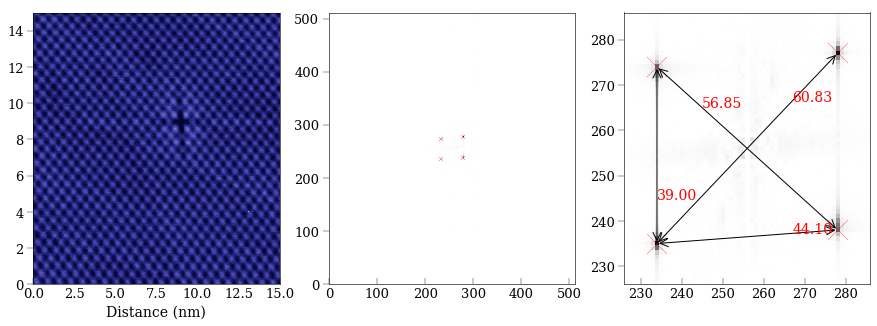

In [13]:
d3.z = stmpy.tools.lineSubtract(d3.Z, 1)
fig, ax = subplots(1,3, figsize=[15,5])
ax[0].imshow(d3.z, cmap=stmpy.cm.blue2, extent=[0,15,0,15])
ax[0].set_xlabel('Distance (nm)')
d3.fft = stmpy.tools.fft(d3.z, zeroDC=True)
peaks = stmpy.tools.find_extrema(d3.fft, n=(5,0), minDist=10)
a1, a2, a3, a4, _ = [array([i,j]) for (i,j) in zip(peaks[:,1],peaks[:,0])]
points = [
(a1, a2),
(a3, a4),
(a2, a3),
(a4, a2),
]

ax[1].imshow(d3.fft, cmap=stmpy.cm.gray_r)
ax[1].plot(peaks[:-1,1], peaks[:-1,0], 'rx',ms = 4)

ax[2].imshow(d3.fft, cmap=stmpy.cm.gray_r)
ax[2].plot(peaks[:,1], peaks[:,0], 'rx',ms = 20)
ax[2].set_xlim([256 - 30, 256 + 30])
ax[2].set_ylim([256 - 30, 256 + 30])
for (p1, p2) in points:
    ax[2].annotate(s='', xy=p1, xytext=p2,size=20, arrowprops=dict(arrowstyle='<->'))
    ax[2].text(*(3*p1+p2)/4, '{:0.2f}'.format(distance(p1,p2)),fontsize=14, color='red')

#savefig('2018-08-28 before calibration.png', dpi=400, bbox_inches='tight')

In [14]:
#A new topo taken 
d4 = stmpy.load('d4.sxm')
d4.z = stmpy.tools.lineSubtract(d4.Z, 1)

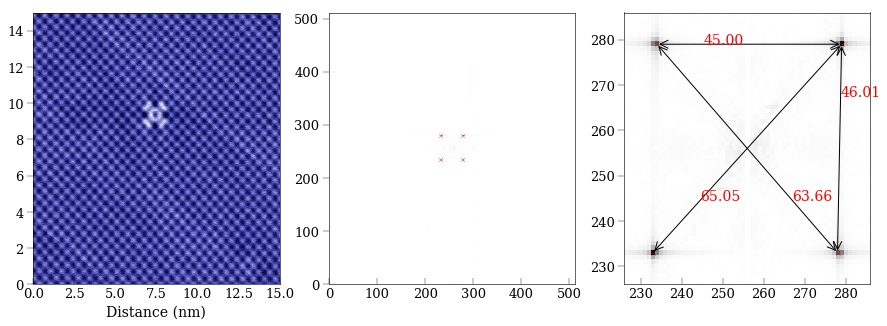

In [15]:
fig, ax = subplots(1,3, figsize=[15,5])
ax[0].imshow(d4.z, cmap=stmpy.cm.blue2, extent=[0,15,0,15])
ax[0].set_xlabel('Distance (nm)')
d4.fft = stmpy.tools.fft(d4.z, zeroDC=True)
peaks = stmpy.tools.find_extrema(d4.fft, n=(5,0), minDist=10)
a1, a2, a3, a4, _ = [array([i,j]) for (i,j) in zip(peaks[:,1],peaks[:,0])]
points = [
(a1, a2),
(a3, a4),
(a2, a3),
(a4, a2),
]

ax[1].imshow(d4.fft, cmap=stmpy.cm.gray_r)
ax[1].plot(peaks[:-1,1], peaks[:-1,0], 'rx',ms = 4)

ax[2].imshow(d4.fft, cmap=stmpy.cm.gray_r)
ax[2].plot(peaks[:,1], peaks[:,0], 'rx')
ax[2].set_xlim([256 - 30, 256 + 30])
ax[2].set_ylim([256 - 30, 256 + 30])
for (p1, p2) in points:
    ax[2].annotate(s='', xy=p1, xytext=p2,size=20, arrowprops=dict(arrowstyle='<->'))
    ax[2].text(*(3*p1+p2)/4, '{:0.2f}'.format(distance(p1,p2)),fontsize=14, color='red')
    
#savefig('2018-08-28 after calibration.png', dpi=400, bbox_inches='tight')

# Summary

__The calibration work here is not perfect, mainly due to following reasons:__

<ol>
  <li>The image size is not large enough. Ideally, a 50 nm topo with 256 points resolution will give a good enough result.</li>
  <li>Drift is large. It's better to take the calibration topo when the LHe level is high, and it's better to take a scanning up topo followed by a scanning downwards topo (or vice versa). Then you can calibrate those two topos separately and obtain final result by averaging them.</li>
    <li>It's okay to not take a topo at $0^{o}$ angle. But then you need to consider a rotation matrix in the distance() function.
    </li>
</ol>